#Data Presentation

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('ca-dealers-used.csv', index_col='id')
df.sort_index()

C:\Users\OLUWAS~1\AppData\Local\Temp/ipykernel_23568/2221995647.py:5: DtypeWarning: Columns (13,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ca-dealers-used.csv', index_col='id')


,vin,price,miles,stock_no,year,make,model,trim,body_type,vehicle_type,drivetrain,transmission,fuel_type,engine_size,engine_block,seller_name,street,city,state,zip
id,,,,,,,,,,,,,,,,,,,,
00000ae8-68e1,KNDJP3A57G7836899,14995.0,75732.0,463,2016.0,Kia,Soul,Plus,Hatchback,Car,FWD,Automatic,Unleaded,2.0,I,gauvin auto lte,389 West Saint Peter Boulevard.,Caraquet,NB,E1W 1A3
00004b94-b5f3,1GKS2GKJ0LR146503,72888.0,5924.0,295016A,2020.0,GMC,Yukon XL,SLT,SUV,Truck,4WD,Automatic,Unleaded,6.2,V,gateway chevrolet,2 Gateway Dr,Brampton,ON,L6T 4A7
000069d2-abee,1FTEW1EG6FFB93664,39480.0,123004.0,SPC3936A,2015.0,Ford,F-150,Lariat,Pickup,Truck,4WD,Automatic,Unleaded,3.5,V,sherwood park chevrolet,500 Premier Way,Sherwood Park,AB,T8H 0R5
0000ad5a-aa21,2T3BFREV4HW658265,20750.0,93825.0,310295A,2017.0,Toyota,RAV4,LE,SUV,Truck,4WD,Automatic,Unleaded,2.5,I,weins canada,3120 Steeles Avenue East,Markham,ON,L3R 1G9
0000d246-c85a,KNDETCA22M7177970,31879.0,2710.0,L20706-2,2021.0,Kia,Seltos,SX,SUV,Truck,4WD,Automatic,Unleaded,1.6,I,land rover vancouver,1730 Burrard Street,Vancouver,BC,V6J 3G7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff5a05-67e6,1FAHP2MK1FG118750,7000.0,211000.0,20N6361,2015.0,Ford,Taurus,NaN,Sedan,NaN,4WD,Automatic,NaN,NaN,NaN,redline auto sales,2040 Dundas St,London,ON,N5V 1R2
ffff6688-8810,5YJSA1H14EFP51474,42988.0,114827.0,P51474,2014.0,Tesla,Model S,S,Hatchback,Car,RWD,Automatic,Electric,NaN,NaN,auto house sunridge,3312 26 Street Northeast,Calgary,AB,T1Y 4T7
ffff7bcd-c582,JTHCE1D29E5003276,24995.0,123895.0,FSPORT,2014.0,Lexus,IS,350,Sedan,Car,4WD,Automatic,Premium Unleaded,3.5,V,montreal ouest motors inc.,55 Chemin De Lotbinire,Vaudreuil-dorion,QC,J7V 2T5


### Contextualization and Description of Variables

Our dataset is the collection of inventory of used cars from various auto dealers across Canada. The data depicts the market activity of used cars sold by different dealers in the various provinces of Canada. The following are the variables in the dataset and their description:

**id** :    Unique identifier for each row.<br>
            *Data type: string*<br>
**vin** :   17 character long vehicle identification number. This is the value that uniquely identify each vehicle.<br> 
            *Data type: string* <br>
**price** : Price of the vehicle. This is the value that we will try to predict.<br>
            *Data type: float* <br>
**miles** : Number of miles/odometer on the vehicle. The higher the number, the more the vehicle has been driven or used.<br>
            *Data type: float* <br>
**year** :  Model year of the vehicle - Decoded from VIN. This is the year the vehicle was manufactured. <br>
            *Data type: float* <br>
**make** :  Make of the vehicle - Decoded from VIN. This is the manufacturer of the vehicle. <br>
            *Data type: string* <br>
**model** : Model of the vehicle - Decoded from VIN. It is the specific model of the vehicle. <br>
            *Data type: string* <br>
**body_type** : Body type of the vehicle - Decoded from VIN. This is the type of vehicle. For example, sedan, coupe, SUV, etc. <br>
            *Data type: string* <br>
**vehicle_type** : This is the type of vehicle. For example, car, truck, etc. <br>
            *Data type: string* <br>
**engine_size** : This is the size of the engine in liters. <br>
            *Data type: float*<br>
**fuel_type** : This is the type of fuel the vehicle uses. For example, gasoline, diesel, etc. <br>
            *Data type: string* <br>
**transmission** : Transmission type of the vehicle. The transmission type is either automatic or manual. <br>
            *Data type: string* <br>
**drivetrain** : Drivetrain type of the vehicle. The drivetrain type is either 4WD, FWD, or RWD. <br>
            *Data type: string* <br>
**seller_name** : Name of the seller or dealership. <br>
            *Data type: string* <br>
**city** : City of the seller or dealership. <br>
            *Data type: string* <br>
**state** : State of the seller or dealership. <br>
            *Data type: string* <br>



In [107]:
display(df.describe())
display(df.info())

,price,miles,year,engine_size
count,3.584860e+05,3.665900e+05,393586.000000,320950.000000
mean,2.601902e+04,7.566339e+04,2016.414829,2.785073
std,2.064007e+04,5.775442e+04,3.345400,1.236639
min,0.000000e+00,0.000000e+00,1981.000000,0.600000
25%,1.490000e+04,3.491375e+04,2015.000000,2.000000
50%,2.190000e+04,6.232800e+04,2017.000000,2.400000
75%,3.199500e+04,1.032830e+05,2019.000000,3.500000
max,1.288888e+06,2.300033e+06,2022.000000,8.400000


<class 'pandas.core.frame.DataFrame'>
Index: 393603 entries, b39ea795-eca9 to 479607ed-62af
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           393603 non-null  object 
 1   price         358486 non-null  float64
 2   miles         366590 non-null  float64
 3   stock_no      365929 non-null  object 
 4   year          393586 non-null  float64
 5   make          393603 non-null  object 
 6   model         388809 non-null  object 
 7   trim          354824 non-null  object 
 8   body_type     359578 non-null  object 
 9   vehicle_type  355365 non-null  object 
 10  drivetrain    354608 non-null  object 
 11  transmission  357922 non-null  object 
 12  fuel_type     322790 non-null  object 
 13  engine_size   320950 non-null  float64
 14  engine_block  320439 non-null  object 
 15  seller_name   391371 non-null  object 
 16  street        385674 non-null  object 
 17  city          385829 non-null  obj

None

In [108]:
#Drop Duplicate VINS so we don't have thesame vehicle more than once
df.drop_duplicates(subset='vin', keep='first', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 226691 entries, b39ea795-eca9 to 479607ed-62af
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           226691 non-null  object 
 1   price         203832 non-null  float64
 2   miles         214003 non-null  float64
 3   stock_no      210828 non-null  object 
 4   year          226678 non-null  float64
 5   make          226691 non-null  object 
 6   model         223824 non-null  object 
 7   trim          199775 non-null  object 
 8   body_type     206027 non-null  object 
 9   vehicle_type  203775 non-null  object 
 10  drivetrain    200702 non-null  object 
 11  transmission  201979 non-null  object 
 12  fuel_type     181432 non-null  object 
 13  engine_size   180550 non-null  float64
 14  engine_block  180131 non-null  object 
 15  seller_name   225486 non-null  object 
 16  street        222762 non-null  object 
 17  city          222865 non-null  obj

In [109]:
# generates and returns a random sample of indices [0...n-1] of length, size_sub_df
# def random_sampler(size_initial_df,  size_sub_df):
#     bin_size = round(size_initial_df/size_sub_df)
#     sample_indices = []
#     low = 0
#     high = 1

#     for i in range(0, size_sub_df+1):
#         sample_indices.append(np.random.randint((low*bin_size), (high*bin_size)))
#         low+=1
#         high+=1

#     return sample_indices

# # generate a list of 1500 random indices between 0 and n-1; n=len(df)
# sample_indices = random_sampler(len(df), 1500)
# # display(sample_indices)

# # use generated indices to sample initial dataframe and create and subset
# df_sub = df.iloc[sample_indices, :]

order_of_cols = ['vin', 'make', 'model', 'year', 'miles', 'price', 'engine_size', 'body_type',  'vehicle_type', 'fuel_type', 'transmission', 'drivetrain', 'seller_name', 'city', 'state']
df_sub = df[order_of_cols]
display(df_sub)


,vin,make,model,year,miles,price,engine_size,body_type,vehicle_type,fuel_type,transmission,drivetrain,seller_name,city,state
id,,,,,,,,,,,,,,,
b39ea795-eca9,19UNC1B01HY800062,Acura,NSX,2017.0,9966.0,179999.0,3.5,Coupe,Car,Electric / Premium Unleaded,Automatic,4WD,edmundston honda,Edmundston,NB
026cb5b1-6e3e,19UNC1B02HY800023,Acura,NSX,2017.0,5988.0,179995.0,3.5,Coupe,Car,Electric / Premium Unleaded,Automatic,4WD,garage daniel lessard,Notre-dame-des-pins,QC
5cd5d5b2-5cc2,19UNC1B02HY800071,Acura,NSX,2017.0,24242.0,168528.0,3.5,Coupe,Car,Electric / Premium Unleaded,Automatic,4WD,lougheed acura,Coquitlam,BC
b32473ed-5922,19UNC1B02LY800001,Acura,NSX,2020.0,6637.0,220000.0,3.5,Coupe,Car,Electric / Premium Unleaded,Automatic,4WD,drive autogroup,Pickering,ON
0487af07-893c,19UNC1B03HY800063,Acura,NSX,2017.0,18281.0,155771.0,3.5,Coupe,Car,Electric / Premium Unleaded,Automatic,4WD,gravel auto crdit,Montral,QC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a02fbcbc-9f63,WDC0G5EB7JV034017,Mercedes-Benz,GLC-Class,2018.0,68665.0,43900.0,2.0,SUV,Truck,Electric / Unleaded,Automatic,4WD,hyundai repentigny,Repentigny,QC
f71c5738-33d8,WDC0G5EB8KF614677,Mercedes-Benz,GLC-Class,2019.0,22108.0,47995.0,2.0,SUV,Truck,Electric / Unleaded,Automatic,4WD,mercedes-benz granby,Granby,QC
873d76f0-18d2,WDC0G5EB9JF465808,Mercedes-Benz,GLC-Class,2018.0,55316.0,42995.0,2.0,SUV,Truck,Electric / Unleaded,Automatic,4WD,groupe park avenue - regroupement automobile,Brossard,QC


C:\Users\OLUWAS~1\AppData\Local\Temp/ipykernel_23568/2944288988.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['age'] = df_sub.year.apply(lambda x: 2022-x) # creating age column to know the age of the vehicles in our dataset


Ages Before
Oldest: 41.0
Newest: 0.0
<class 'pandas.core.frame.DataFrame'>
Index: 226691 entries, b39ea795-eca9 to 479607ed-62af
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           226691 non-null  object 
 1   make          226691 non-null  object 
 2   model         223824 non-null  object 
 3   year          226678 non-null  float64
 4   miles         214003 non-null  float64
 5   price         203832 non-null  float64
 6   engine_size   180550 non-null  float64
 7   body_type     206027 non-null  object 
 8   vehicle_type  203775 non-null  object 
 9   fuel_type     181432 non-null  object 
 10  transmission  201979 non-null  object 
 11  drivetrain    200702 non-null  object 
 12  seller_name   225486 non-null  object 
 13  city          222865 non-null  object 
 14  state         222802 non-null  object 
 15  age           226678 non-null  float64
dtypes: float64(5), object(11)
memory usage: 2

None

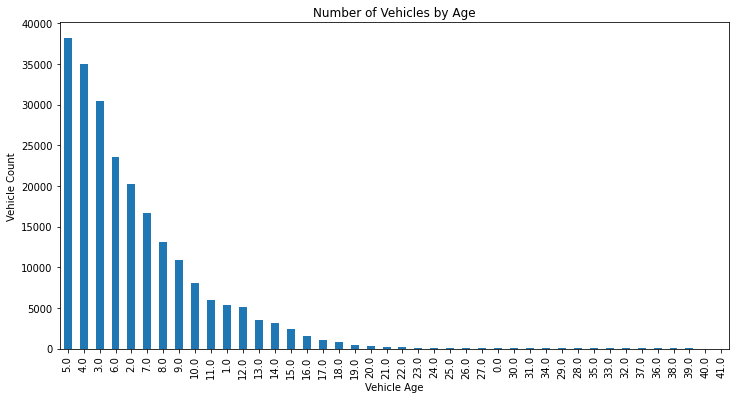

In [110]:
# df_sub['year'] = df_sub['year'].astype('int') # convert year to integer because years cannot have decimal points

df_sub['age'] = df_sub.year.apply(lambda x: 2022-x) # creating age column to know the age of the vehicles in our dataset
print(f"Ages Before\nOldest: {df_sub['age'].max()}\nNewest: {df_sub['age'].min()}")
display(df_sub.info())

# """We will plot a line plot to see the number of vehicles by age in order to know if we should keep or drop
# rows based on the age of the vehicle"""

#Plotting the numbers of vehicles by year
df_sub['age'].value_counts().plot(kind='bar', figsize = (12, 6), title = 'Number of Vehicles by Age')
plt.xlabel('Vehicle Age')
plt.ylabel('Vehicle Count')
plt.show()

Ages After
Oldest: 15.0
Newest: 0.0
<class 'pandas.core.frame.DataFrame'>
Index: 221742 entries, b39ea795-eca9 to 479607ed-62af
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           221742 non-null  object 
 1   make          221742 non-null  object 
 2   model         219143 non-null  object 
 3   year          221742 non-null  float64
 4   miles         209571 non-null  float64
 5   price         200716 non-null  float64
 6   engine_size   177244 non-null  float64
 7   body_type     201738 non-null  object 
 8   vehicle_type  199542 non-null  object 
 9   fuel_type     178168 non-null  object 
 10  transmission  198074 non-null  object 
 11  drivetrain    196942 non-null  object 
 12  seller_name   220579 non-null  object 
 13  city          218043 non-null  object 
 14  state         217984 non-null  object 
 15  age           221742 non-null  float64
dtypes: float64(5), object(11)
memory usage: 28

None

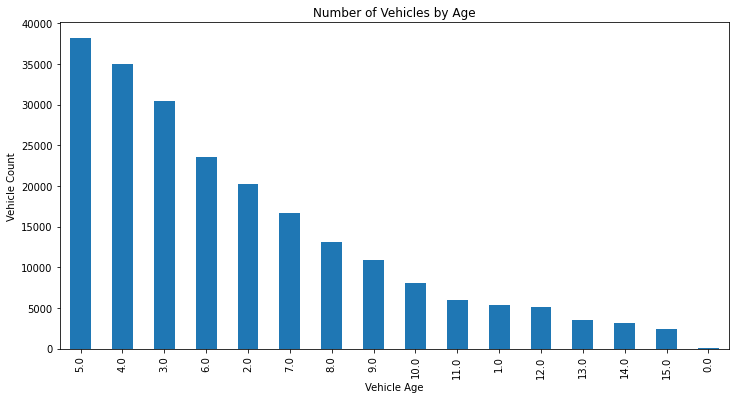

In [111]:
"""
From our plot, we can observe that the vehicles that are newer have higher numbers than older vehicles.
We will therefore drop rows with older cars. We will work with cars between ages 1 - 15
"""

df_sub = df_sub[(df_sub['age']>= 0) & (df_sub['age'] <= 15)] # removing vehicles that are older than 20 years old
print(f"Ages After\nOldest: {df_sub['age'].max()}\nNewest: {df_sub['age'].min()}")
display(df_sub.info())

#Plotting the numbers of vehicles by year after removi g older cars
df_sub['age'].value_counts().plot(kind='bar',figsize = (12, 6), title = 'Number of Vehicles by Age')
plt.xlabel('Vehicle Age')
plt.ylabel('Vehicle Count')
plt.show()

In [112]:
#Function to delete random data from a column
def drop_random_rows(data, attribute, fraction):
    for col in data.columns:
        if col == attribute:
            data.loc[data.sample(frac=fraction).index, col] = np.nan
            
drop_random_rows(df_sub, 'year', 0.2) #Remove 20% data from year
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221742 entries, b39ea795-eca9 to 479607ed-62af
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           221742 non-null  object 
 1   make          221742 non-null  object 
 2   model         219143 non-null  object 
 3   year          177394 non-null  float64
 4   miles         209571 non-null  float64
 5   price         200716 non-null  float64
 6   engine_size   177244 non-null  float64
 7   body_type     201738 non-null  object 
 8   vehicle_type  199542 non-null  object 
 9   fuel_type     178168 non-null  object 
 10  transmission  198074 non-null  object 
 11  drivetrain    196942 non-null  object 
 12  seller_name   220579 non-null  object 
 13  city          218043 non-null  object 
 14  state         217984 non-null  object 
 15  age           221742 non-null  float64
dtypes: float64(5), object(11)
memory usage: 36.8+ MB


In [113]:
"""
We are able to fill missing year from Vehicle VIN.
This function generates year of the vehicle from the VIN.
"""

def generate_year(vin):
    decoder = {'1':'2001', '2': '2002', '3': '2003', '4':'2004', '5':'2005', '6':'2006', '7':'2007', '8':'2008', '9':'2009', 'A':'2010', 'B':'2011', 
               'C':'2012', 'D':'2013', 'E':'2014', 'F':'2015', 'G':'2016', 'H':'2017', 'J':'2018', 'K':'2019', 'L':'2020', 'M':'2021', 'N':'2022'}
    vin = str(vin)
    if (len(vin) != 17) :
        return
    else:
        year_code = str(vin)[-8]
        
        for key,value in decoder.items():
            if year_code == key:
                return value      
    
df_sub['year'] = df_sub['vin'].apply(generate_year)
df_sub.sort_values(by=['year'], ascending=False)
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221742 entries, b39ea795-eca9 to 479607ed-62af
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           221742 non-null  object 
 1   make          221742 non-null  object 
 2   model         219143 non-null  object 
 3   year          221742 non-null  object 
 4   miles         209571 non-null  float64
 5   price         200716 non-null  float64
 6   engine_size   177244 non-null  float64
 7   body_type     201738 non-null  object 
 8   vehicle_type  199542 non-null  object 
 9   fuel_type     178168 non-null  object 
 10  transmission  198074 non-null  object 
 11  drivetrain    196942 non-null  object 
 12  seller_name   220579 non-null  object 
 13  city          218043 non-null  object 
 14  state         217984 non-null  object 
 15  age           221742 non-null  float64
dtypes: float64(4), object(12)
memory usage: 36.8+ MB


In [114]:
# average_price = df_sub.groupby(['year', 'miles']).agg({'price':['mean']}).sort_values(by=['year', 'miles'], ascending=False)
# average_price['price']

<AxesSubplot:>

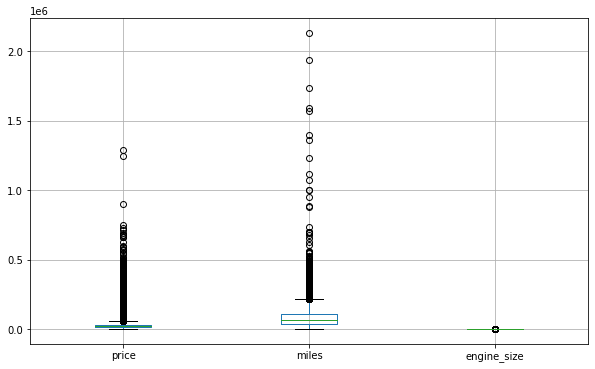

In [115]:
# #Plottng box plots to get outliers from price and miles
df_sub.boxplot(column=['price', 'miles', 'engine_size'], figsize=(10,6))

# def remove_outliers(data, x):
#         q25 = np.percentile(data[x], 25)
#         q75 = np.percentile(data[x], 75)
#         iqr = q75 - q25
#         lower_bound = q25 - (1.5 * iqr)
#         upper_bound = q75 + (1.5 * iqr)
#         return data[(data[x] > lower_bound) & (data[x] < upper_bound)]
         
# df_sub = remove_outliers(df_sub, 'price')
# df_sub.info()
    


In [116]:
df_sub.describe()

,miles,price,engine_size,age
count,2.095710e+05,2.007160e+05,177244.000000,221742.000000
mean,7.787736e+04,2.561266e+04,2.771274,5.699137
std,5.796492e+04,2.120466e+04,1.223874,3.070274
min,0.000000e+00,0.000000e+00,0.600000,0.000000
25%,3.602400e+04,1.399900e+04,2.000000,3.000000
50%,6.520000e+04,2.099900e+04,2.400000,5.000000
75%,1.090000e+05,3.179725e+04,3.500000,7.000000
max,2.136090e+06,1.288888e+06,8.400000,15.000000
